In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train_full = x_train_full.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [3]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
    
def show_reconstructions(model, images=x_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='sigmoid'),
])

simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28]),
])

simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.SGD(learning_rate=1.), 
                  metrics=[rounded_accuracy])

In [5]:
history = simple_ae.fit(x_train, x_train, epochs=10, 
                        validation_data=(x_valid, x_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4329 - rounded_accuracy: 0.7950 - val_loss: 0.3773 - val_rounded_accuracy: 0.8492
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3612 - rounded_accuracy: 0.8668 - val_loss: 0.3514 - val_rounded_accuracy: 0.8797
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3410 - rounded_accuracy: 0.8852 - val_loss: 0.3367 - val_rounded_accuracy: 0.8912
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3288 - rounded_accuracy: 0.8954 - val_loss: 0.3263 - val_rounded_accuracy: 0.8992
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3213 - rounded_accuracy: 0.9012 - val_loss: 0.3210 - val_rounded_accuracy: 0.9032
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3176 - rounded_accuracy: 0.9038 - val_loss: 0.3179 - val_rounded_accuracy: 0.9050
Epoch 7/10
1719/1719 [==================

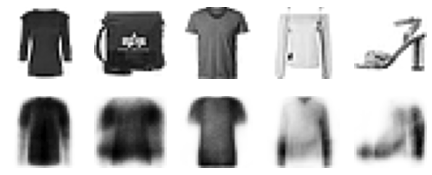

In [6]:
show_reconstructions(simple_ae)
plt.show()

In [7]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [8]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    x_valid_codings = encoder(x_valid).numpy()
    activation_means = x_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, x_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

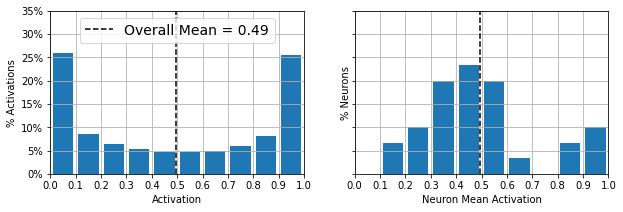

In [9]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid'),
    keras.layers.ActivityRegularization(l1=1e-3),
])

sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28]),
])

sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.SGD(learning_rate=1.), 
                     metrics=[rounded_accuracy])

In [11]:
history = sparse_l1_ae.fit(x_train, x_train, epochs=10, 
                           validation_data=(x_valid, x_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [==================

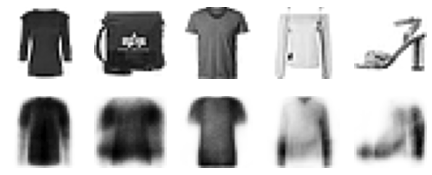

In [12]:
show_reconstructions(simple_ae)
plt.show()

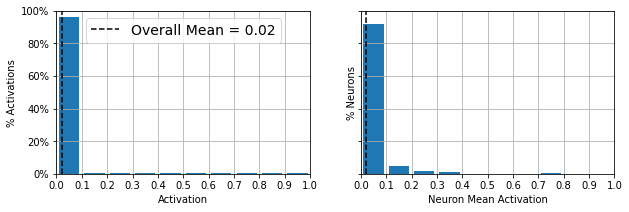

In [13]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

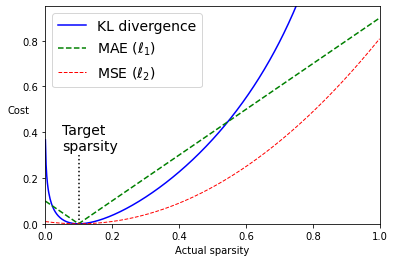

In [14]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.show()

In [15]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)

sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid', activity_regularizer=kld_reg),
])

sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.SGD(learning_rate=1.), 
                     metrics=[rounded_accuracy])

In [17]:
history = sparse_kl_ae.fit(x_train, x_train, epochs=10, 
                           validation_data=(x_valid, x_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4150 - rounded_accuracy: 0.8121 - val_loss: 0.3716 - val_rounded_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3531 - rounded_accuracy: 0.8763 - val_loss: 0.3442 - val_rounded_accuracy: 0.8847
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3340 - rounded_accuracy: 0.8918 - val_loss: 0.3293 - val_rounded_accuracy: 0.8975
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9043
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3135 - rounded_accuracy: 0.9093 - val_loss: 0.3140 - val_rounded_accuracy: 0.9105
Epoch 7/10
1719/1719 [==================

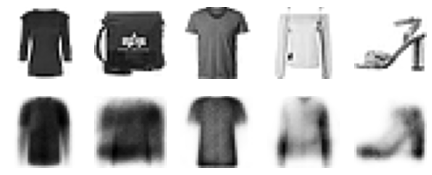

In [18]:
show_reconstructions(sparse_kl_ae)
plt.show()

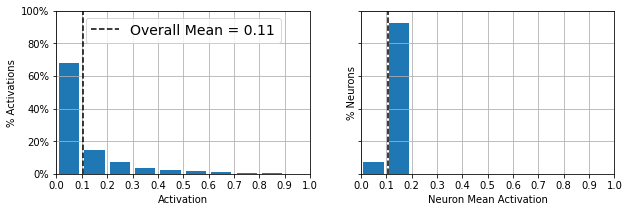

In [19]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()